# **French Motor Third-Party Liability Claims**

# Fitting a GLM using keras

Jürg Schelldorfer

2021-12-12

# Table of contents
1. [Introduction](#intro) 
2. [Data Preparation](#dataPrep)             
      2.1 [Load packages](#pkg)             
      2.2 [Set global parameters](#paramSeed)             
      2.3 [Helper functions](#helpers)             
      2.4 [Load data](#loadData)                   
      2.5 [General preprocessing](#genProcess)          
      2.6 [Store model results](#storeModel)
3. [Pre-processing Neural Networks](#ppNN)                       
    3.1 [Introduction](#ppNNintro)                          
    3.2 [Pre-processing functions](#ppNNfct)                       
    3.3 [Execute pre-processing](#ppNNexec)          
    3.4 [Inspect the pre-processed data](#ppNNinspect)              
    3.5 [Split train and test data](#splitraintest)            
    3.6 [Common neural network specifications](#ppNNspec)           
4. [Designing neural networks](#DsgNN)                            
    4.1 [Gradient descent methods](#gdm)                
    4.2 [Epochs and batches](#epbatch)      
    4.3 [Initialization](#init)           
    4.4 [Activation function](#)
5. [Generalized Linear Model using `keras(...)`](#M1)                             
    5.1 [Definition](#M1def)                  
    5.2 [Compilation](#M1com)                
    5.3 [Fitting](#M1fit)                     
    5.4 [Validation](#M1val)                    
6. [Generalized Linear Model using `glm(...)`](#M2)                                        
    6.1 [Fitting](#M2fit)                              
    6.2 [Validation](#M2val)                                     
7. [Model Comparison](#MC)             
    7.1 [Compare fitted values](#MCfit)               
    7.2 [Compare coefficients/weights](#MCcoef)               
8. [Remarks](#rmk)
9. [Session Info](#session)

# 1. Introduction<a name="intro"></a>

This notebook was created for the course "Deep Learning with Actuarial Applications in R" of the Swiss Association of Actuaries (https://www.actuaries.ch/).

This notebook serves as accompanion to the tutorial “Insights from Inside Neural Networks”, available on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852).

The code is similar to the code used in above tutorial and combines the raw R code in the scripts, available on [GitHub](https://github.com/JSchelldorfer/ActuarialDataScience/tree/master/2%20-%20Insights%20from%20Inside%20Neural%20Networks) along with some more comments. Please refer to the tutorial for explanations.

Note that the results might vary depending on the R and Python package versions, see last section for the result of `sessionInfo()` and corresponding info on the Python setup.

# 2. Data Preparation<a name="dataPrep"></a>

The tutorial uses the French MTPL data set available on [openML (ID 41214)](https://www.openml.org/d/41214).

## 2.1 Load packages<a name="pkg"></a>

In [1]:
library(mgcv)
library(keras)
library(magrittr)
library(dplyr)
library(tibble)
library(purrr)
library(ggplot2)
library(gridExtra)
library(splitTools)
library(tidyr)
library(OpenML)
library(farff)

Loading required package: nlme

This is mgcv 1.8-33. For overview type 'help("mgcv-package")'.


Attaching package: ‘dplyr’


The following object is masked from ‘package:nlme’:

    collapse


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘purrr’


The following object is masked from ‘package:magrittr’:

    set_names



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘tidyr’


The following object is masked from ‘package:magrittr’:

    extract




## 2.2 Set global parameters<a name="paramSeed"></a>

In [2]:
options(encoding = 'UTF-8')

In [3]:
# set seed to obtain best reproducibility. note that the underlying architecture may affect results nonetheless, so full reproducibility cannot be guaranteed across different platforms.
seed <- 100
Sys.setenv(PYTHONHASHSEED = seed)
set.seed(seed)
reticulate::py_set_seed(seed)
tensorflow::tf$random$set_seed(seed)

The results below will not exactly match the results in the paper, since the underlying dataset and some packages are different. In addition the split into training and testing data is different as well. However, the general conclusions remain the same.

## 2.3 Helper functions<a name="helpers"></a>

Subsequently, for ease of reading, we provide all the helper functions which are used in this tutorial in this section.

In [4]:
# Poisson deviance
PoissonDeviance <- function(pred, obs) {
    200 * (sum(pred) - sum(obs) + sum(log((obs/pred)^(obs)))) / length(pred)
}

# 2.4 Load data<a name="loadData"></a>

We consider the data `freMTPL2freq` included in the R package `CASdatasets` for claim frequency modeling. This data comprises a French motor third-party liability (MTPL) insurance portfolio with corresponding claim counts observed in one accounting year.
We do not incorporate claim sizes which would also be available through freMTPL2sev.

As the current package version provides a slightly amended dataset, we use an older dataset available on [openML (ID 41214)](https://www.openml.org/d/41214) to allow replication of the results in the tutorial.

There are two options to load this dataset:
- Option 1: Manually download the data from [github](https://github.com/JSchelldorfer/DeepLearningWithActuarialApplications/) in case of firewalls or other issues
- Option 2: Download from [openML (ID 41214)](https://www.openml.org/d/41214)

In [5]:
# Local loading
# you can download it from https://github.com/JSchelldorfer/DeepLearningWithActuarialApplications/blob/master/freMTPL2freq.RData
load("/home/s3m3wx/SAV_2021_Blockcourse/1_glm/freMTPL2freq.RData")

# download (only if company firewall allows it)
#freMTPL2freq <- getOMLDataSet(data.id = 41214)$data

## 2.5 General data preprocessing<a name="genProcess"></a>

A priori, there is not sufficient information about this data to do a sensible decision about the best consideration of the exposure measure, either as feature or as offset. In the following we treat the exposure always as an offset.

Data preprocessing includes a couple of transformations. We ensure that ClaimNb is an integer, VehAge, DrivAge and BonusMalus have been capped for the plots at age 20, age 90 and bonus-malus level 150, respectively, to improve visualization. Density is logarithmized and VehGas is a categorical variable. We leave away the rounding used in the first notebook, which were mainly used for nicer visualizations of the data.

We are adding a group_id identifying rows possibly referring to the same policy. Respecting group_id in data splitting techniques (train/test, cross-validation) is essential. This is different to the tutorial where another splitting has been used. As a consequence, the figures in this notebook do not match the figures in the tutorial, but the conclusions drawn are the same.

In addition to the previous tutorial, we decide to truncate the ClaimNb and the Exposure in order to correct for unreasonable data entries and simplifications for the modeling part.

In [6]:
# Grouping id
distinct <- freMTPL2freq %>% 
  distinct_at(vars(-c(IDpol, Exposure, ClaimNb))) %>% 
  mutate(group_id = row_number())

In [7]:
dat <- freMTPL2freq %>% 
  left_join(distinct) %>% 
  mutate(ClaimNb = pmin(as.integer(ClaimNb), 4),
         VehAge = pmin(VehAge,20),
         DrivAge = pmin(DrivAge,90),
         BonusMalus = pmin(BonusMalus,150),
         Density = round(log(Density),2),
         VehGas = factor(VehGas),
         Exposure = pmin(Exposure, 1))

Joining, by = c("Area", "VehPower", "VehAge", "DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region", "ClaimTotal")



In [8]:
# Group sizes of suspected clusters
table(table(dat[, "group_id"]))


     1      2      3      4      5      6      7      8      9     10     11 
429576  84201  13940   2437    966    754    720    475    400    269    142 
    12     13     14     15     18     22 
   191      3      1      2      1      1 

## 2.6 Store model results<a name="storeModel"></a>

As we are going to compare two models, we create a table which stores the metrics we are going to use for the comparison and the selection of the best model.

In [9]:
# initialize table to store all model results for comparison
df_cmp <- tibble(
 model = character(),
 epochs = numeric(),
 run_time = numeric(),
 parameters = numeric(),
 in_sample_loss = numeric(),
 out_sample_loss = numeric(),
 avg_freq = numeric(),
)

# 3. Pre-processing Neural Networks<a name="ppNN"></a>

## 3.1 Introduction<a name="ppNNintro"></a>

In this chapter, we explain how the data need to be pre-processed to be used in neural networks. It can not be processed in the same way as shown above for GLMs. Further details can be found in this tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852), chapter 2.

We are going to highlight a few important points in data pre-processing that are necessary for a successful application of networks.

In network modeling the choice of the scale of the feature components may substantially influence the fitting procedure of the predictive model. Therefore, data pre-processing requires careful consideration. We treat unordered categorical (nominal) feature components and continuous (or ordinal) feature components separately. Ordered categorical feature components are treated like continuous ones, where we simply replace the ordered categorical labels by integers. Binary categorical feature components are coded by 0's and 1's for the two binary labels (for binary labels we do not distinguish between ordered and unordered components). Remark that if we choose an anti-symmetric activation function, i.e. $-\phi(x) = \phi(-x)$, we may also set binary
categorical feature components to $\pm 1/2$, which may simplify initialization of optimization
algorithms.

### 3.1.1 Unordered (nominal) categorical feature components

We need to transform (nominal) categorical feature components to numerical values. The most commonly used transformations are the so-called **dummy coding** and the **one-hot encoding**. Both methods construct binary representations for categorical labels. For dummy coding one label is chosen as reference level. Dummy coding then uses binary variables to indicate which label a particular policy possesses if it differs from the reference level. In our example we have two unordered categorical feature components, namely VehBrand and Region. We use VehBrand as
illustration. It has 11 different labels $\{B_1, B_{10}, B_{11}, B_{12}, B_{13}, B_{14}, B_2, B_3, B_4, B_5, B_6\}$. We choose
$B_1$ as reference label. Dummy coding then provides the coding scheme below (left). We observe that the 11 labels are replaced by 10-dimensional feature vectors $\{0,1\}^{10}$, with components summing up to either 0 or 1.

![2_fnn](Figure_Encoding.PNG)

In contrast to dummy coding, one-hot encoding does not choose a reference level, but uses an indicator for each label. In this way the 11 labels of VehBrand are replaced by the 11 unit vectors. The main difference between dummy coding and one-hot encoding is that the former leads to full rank design matrices, whereas the latter does not. This implies that under one-hot encoding there are identifiability issues in parametrizations. In network modeling identifiability is less important because we typically work in over-parametrized nonconvex optimization problems (with multiple equally good models/parametrizations); on the other hand, identifiability in GLMs is an important feature because one typically tries to solve a convex optimization problem, where the full rank property is important to efficiently  and the (unique) solution.

Remark that other coding schemes could be used for categorical feature components such as Helmert's contrast coding. In classical GLMs the choice of the coding scheme typically does not influence the prediction, however, interpretation of the results may change by considering
a different contrast. In network modeling the choice of the coding scheme may influence the prediction: typically, we exercise an early stopping rule in network calibrations. This early stopping rule and the corresponding result may depend on any chosen modeling strategy, such
as the encoding scheme of categorical feature components.

Remark that dummy coding and one-hot encoding may lead to very high-dimensional input layers in networks, and it provides sparsity in input features. Moreover, the Euclidean distance between any two labels in the one-hot encoding scheme is that same. From natural language
processing (NLP) we have learned that there are more efficient ways of representing categorical feature components, namely, by embedding them into lower-dimensional spaces so that proximity in these spaces has a useful meaning in the regression task. In networks this can be achieved by
so-called embedding layers. In the context of our French MTPL example we refer to our next notebook.

### 3.1.2 Continuous feature components

In theory, continuous feature components do not need pre-processing if we choose a sufficiently rich network, because the network may take care of feature components living on different scales. This statement is of purely theoretical value. In practice, continuous feature components need
pre-processing such that they all live on a similar scale and such that they are sufficiently equally distributed across this scale. The reason for this requirement is that the calibration algorithms mostly use gradient descent methods (GDMs). These GDMs only work properly, if
all components live on a similar scale and, thus, all directions contribute equally to the gradient.
Otherwise, the optimization algorithms may get trapped in saddle points or in regions where the gradients are at (also known as vanishing gradient problem). Often, one uses $[-1,+1]$ as the common scale because the/our choice of activation function is focused to that scale.

A popular transformation is the so-called MinMaxScaler. For this transformation we fix each continuous feature component of $x$, say $x_l$, at a time. Denote the minimum and the maximum of the domain of $x_l$ by $m_l$ and $M_l$, respectively. The MinMaxScaler then replaces

![2_fnn](Figure_MinMaxScaler.PNG)

In practice, it may happen that the minimum ml or the maximum Ml is not known. In this case one chooses the corresponding minimum and/or maximum of the features in the observed data. For prediction under new features one then needs to keep the original scaling of the initially
observed data, i.e. the one which has been used for model calibration.

Remark that if we have outliers, the above transformations may lead to very concentrated transformed feature components $x_l^*$, $i=1,...,n$, because the outliers may, for instance, dominate the maximum in the MinMaxScaler. In this case, feature components should be transformed
first by a log-transformation or by a quantile transformation so that they become more equally spaced (and robust) across the real line.

### 3.1.3 Binary feature components

We observe that binary feature components (e.g. gender) are often embedded in the ML literature into a higher-dimensional space. However, we are of the opinion that this does not make sense. Hence, we suggest to set binary categorical feature components to $\pm 1/2$.

### 3.1.4 Summary

As a rule of thumb one could formulate it as follows:
- continuous features $\Rightarrow$ scale to $[-1,+1]$ (if no outliers)
- binary features $\Rightarrow$ set to $\{-1/2,+1/2 \}$
- categorical features:
     * make them numerical $\Rightarrow$ scale to $[-1,+1]$
     * One-hot encoding $\Rightarrow$ no scaling
     * dummy encoding $\Rightarrow$ no scaling
     * embedding $\Rightarrow$ made numerical and no scaling

## 3.2 Pre-processing functions<a name="ppNNfct"></a>

In our example we use dummy coding for the feature components VehBrand and Region. We use the MinMaxScaler for Area (after transforming $\{A,...,F\}$ $\mapsto$ $\{1,...,6\}$), VehPower, VehAge (after capping at age 20), DrivAge (after capping at age 90), BonusMalus (after capping at level 150) and Density (after first taking the log-transform). VehGas we transform to $\pm 1/2$ and the volume Exposure $\in (0,1]$ we keep untransformed.

Below the corresponding pre-processing functions:

In [10]:
# MinMax scaler
preprocess_minmax <- function(varData) {
  X <- as.numeric(varData)
  2 * (X - min(X)) / (max(X) - min(X)) - 1
}

# Dummy coding 
preprocess_catdummy <- function(data, varName, prefix) {
  varData <- data[[varName]]
  X <- as.integer(varData)
  n0 <- length(unique(X))
  n1 <- 2:n0
  addCols <- purrr::map(n1, function(x, y) {as.integer(y == x)}, y = X) %>%
    rlang::set_names(paste0(prefix, n1))
  cbind(data, addCols)
}

# Feature pre-processing using MinMax Scaler and Dummy Coding
preprocess_features <- function(data) {
  data %>%
    mutate_at(
      c(AreaX = "Area", VehPowerX = "VehPower", VehAgeX = "VehAge",
        DrivAgeX = "DrivAge", BonusMalusX = "BonusMalus", DensityX = "Density"),
      preprocess_minmax
    ) %>%
    mutate(
      VehGasX = as.integer(VehGas) - 1.5
    ) %>%
    preprocess_catdummy("VehBrand", "Br") %>%
    preprocess_catdummy("Region", "R")
}


## 3.3 Execute pre-processing<a name="ppNNexec"></a>

In [11]:
dat2 <- preprocess_features(dat)

## 3.4 Inspect the pre-processed data<a name="ppNNinspect"></a>

In [12]:
head(dat2)

,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,⋯,R13,R14,R15,R16,R17,R18,R19,R20,R21,R22
,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0.10,D,5,0,55,50,B12,Regular,7.10,⋯,0,0,0,0,0,1,0,0,0,0
2,3,0.77,D,5,0,55,50,B12,Regular,7.10,⋯,0,0,0,0,0,1,0,0,0,0
3,5,0.75,B,6,2,52,50,B12,Diesel,3.99,⋯,0,0,0,0,0,0,0,0,0,0
4,10,0.09,B,7,0,46,50,B12,Diesel,4.33,⋯,0,0,1,0,0,0,0,0,0,0
5,11,0.84,B,7,0,46,50,B12,Diesel,4.33,⋯,0,0,1,0,0,0,0,0,0,0
6,13,0.52,E,6,2,38,50,B12,Regular,8.01,⋯,0,0,0,0,0,0,0,0,0,0


In [13]:
str(dat2)

'data.frame':	678007 obs. of  52 variables:
 $ IDpol      : num  1 3 5 10 11 13 15 17 18 21 ...
 $ Exposure   : num  0.1 0.77 0.75 0.09 0.84 0.52 0.45 0.27 0.71 0.15 ...
 $ Area       : Factor w/ 6 levels "A","B","C","D",..: 4 4 2 2 2 5 5 3 3 2 ...
 $ VehPower   : num  5 5 6 7 7 6 6 7 7 7 ...
 $ VehAge     : num  0 0 2 0 0 2 2 0 0 0 ...
 $ DrivAge    : num  55 55 52 46 46 38 38 33 33 41 ...
 $ BonusMalus : num  50 50 50 50 50 50 50 68 68 50 ...
 $ VehBrand   : Factor w/ 11 levels "B1","B2","B3",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ VehGas     : Factor w/ 2 levels "Diesel","Regular": 2 2 1 1 1 2 2 1 1 1 ...
 $ Density    : num  7.1 7.1 3.99 4.33 4.33 8.01 8.01 4.92 4.92 4.09 ...
 $ Region     : Factor w/ 22 levels "R11","R21","R22",..: 18 18 3 15 15 8 8 20 20 12 ...
 $ ClaimTotal : num  0 0 0 0 0 0 0 0 0 0 ...
 $ ClaimNb    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ group_id   : int  1 1 2 3 3 4 4 5 5 6 ...
 $ AreaX      : num  0.2 0.2 -0.6 -0.6 -0.6 0.6 0.6 -0.2 -0.2 -0.6 ...
 $ VehPowerX  : num  -0.8

In [14]:
summary(dat2)

     IDpol            Exposure        Area          VehPower     
 Min.   :      1   Min.   :0.002732   A:103957   Min.   : 4.000  
 1st Qu.:1157948   1st Qu.:0.180000   B: 75459   1st Qu.: 5.000  
 Median :2272153   Median :0.490000   C:191880   Median : 6.000  
 Mean   :2621857   Mean   :0.528547   D:151590   Mean   : 6.455  
 3rd Qu.:4046278   3rd Qu.:0.990000   E:137167   3rd Qu.: 7.000  
 Max.   :6114330   Max.   :1.000000   F: 17954   Max.   :15.000  
                                                                 
     VehAge          DrivAge       BonusMalus        VehBrand     
 Min.   : 0.000   Min.   :18.0   Min.   : 50.00   B12    :166024  
 1st Qu.: 2.000   1st Qu.:34.0   1st Qu.: 50.00   B1     :162730  
 Median : 6.000   Median :44.0   Median : 50.00   B2     :159861  
 Mean   : 6.976   Mean   :45.5   Mean   : 59.76   B3     : 53395  
 3rd Qu.:11.000   3rd Qu.:55.0   3rd Qu.: 64.00   B5     : 34753  
 Max.   :20.000   Max.   :90.0   Max.   :150.00   B6     : 28548  
   

## 3.5 Split train and test data<a name="splitraintest"></a>

First, we split the dataset into train and test. Due to the potential grouping of rows in policies we can not just do a random split. For this purpose, we use the function `partition(...)` from the `splitTools` package.

In [15]:
ind <- partition(dat2[["group_id"]], p = c(train = 0.8, test = 0.2), 
                 seed = seed, type = "grouped")
train <- dat2[ind$train, ]
test <- dat2[ind$test, ]

In [16]:
# size of train/test
sprintf("Number of observations (train): %s", nrow(train))
sprintf("Number of observations (test): %s", nrow(test))

# Claims frequency of train/test
sprintf("Empirical frequency (train): %s", round(sum(train$ClaimNb) / sum(train$Exposure), 4))
sprintf("Empirical frequency (test): %s", round(sum(test$ClaimNb) / sum(test$Exposure), 4))

[1] "Number of observations (train): 542331"

[1] "Number of observations (test): 135676"

[1] "Empirical frequency (train): 0.0736"

[1] "Empirical frequency (test): 0.0736"

## 3.6 Common neural network specifications<a name="ppNNspec"></a>

In this section, we define objects and parameters which are used for all subsequent neural networks considered, independent of their network structure.

We need to define which components in the pre-processed dataset `dat2` are used as input features. As we have added the pre-processed features appropriate for the neural networks to the original features, we only must use the relevant ones.

In [17]:
# select the feature space
col_start <- ncol(dat) + 1
col_end <- ncol(dat2)
features <- c(col_start:col_end) # select features, be careful if pre-processing changes
print(colnames(train[, features]))

 [1] "AreaX"       "VehPowerX"   "VehAgeX"     "DrivAgeX"    "BonusMalusX"
 [6] "DensityX"    "VehGasX"     "Br2"         "Br3"         "Br4"        
[11] "Br5"         "Br6"         "Br7"         "Br8"         "Br9"        
[16] "Br10"        "Br11"        "R2"          "R3"          "R4"         
[21] "R5"          "R6"          "R7"          "R8"          "R9"         
[26] "R10"         "R11"         "R12"         "R13"         "R14"        
[31] "R15"         "R16"         "R17"         "R18"         "R19"        
[36] "R20"         "R21"         "R22"        


The input to keras requires the train and testing data to be of matrix format, including all features used in the matrix and already correctly pre-processed.

In [18]:
# feature matrix
Xtrain <- as.matrix(train[, features])  # design matrix training sample
Xtest <- as.matrix(test[, features])    # design matrix test sample

# 4. Designing neural networks<a name="DsgNN"></a>

The choice of a particular network architecture and its calibration involve many steps. In each of these steps the modeler has to make
certain decisions, and it may require that each of these decisions is revised several times in order to get the best (or more modestly a good) predictive model.

In this section we provide a short explanation on the ones explicitly used below. We refer to this tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852) and further literature (provided below in the last chapter) to learn more about these hyperparameters and the way to choose the right architecture.

The tutorial covers the choice of a particular network architecture and its calibration. In each of these steps the modeler has to make
certain decisions, and it may require that each of these decisions is revised several times in order to get the best (or more modestly a good) predictive model. The choices involve:

![2_fnn](Figure_DesignDecisions.PNG)

## 4.1 Gradient descent methods <a name="gdm"></a>

There are seval optimizers availble to find the solution to a neural networks, a short description as follows:

- The stochastic gradient descent method, called 'sgd', can be fine-tuned for the speed of convergence by using optimal learning rates, momentum-based improvements, the Nesterov acceleration and optimal batches. `stochastic' gradient means that in contrast to (steepest) gradient descent, we explore locally optimally steps on random sub-samples
- 'adagrad' chooses learning rates that differ in all directions of the gradient and that consider
the directional sizes of the gradients ('ada' stands for adapted);
- 'adadelta' is a modied version of 'adagrad' that overcomes some deficiencies of the latter,
for instance, the sensitivity to hyperparameters;
- 'rmsprop' is another method to overcome the deficiencies of 'adagrad' ('rmsprop' stands
for root mean square propagation);
- 'adam' stands for adaptive moment estimation, similar to 'adagrad' it searches for directionally
optimal learning rates based on the momentum induced by past gradients
measured by an `2-norm;
- 'adamax' considers optimal learning rates as 'adam' but based on the $l_1$-norm;
- 'nadam' is a Nesterov accelerated version of 'adam'.

In the tutorial on [SSRN](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3226852), chapter 4 the performance of the various optimizers are analyzed. The study shows that `nadam` is a good candiate to be used.

In [19]:
# available optimizers for keras
# https://keras.io/optimizers/
optimizers <- c('sgd', 'adagrad', 'adadelta', 'rmsprop', 'adam', 'adamax', 'nadam')

## 4.2 Epochs and batches<a name="epbatch"></a>

Epochs indicates how many times we go through the entire learning data $\mathcal{D}$, and batch size indicates the size of the subsamples considered in each Gradient Descent Method (GDM) step. Thus, if the batch size is equal to the number of observations $n$ we do exactly one GDM step in one epoch, if the batch size is equal to 1 then we do n GDM steps in one epoch until we have seen the entire learning data  $\mathcal{D}$. Note that smaller batches are needed for big data because it is not feasible to simultaneously calculate the gradient on all data efficiently if we have many observations. Therefore, we partition the entire data at random into (mini-) batches in the application of the GDM. Note that this partitioning of the data is of particular interest if we work with big data because it allows us to explore the data sequentially.

Concretly, for the maximal batch size $n$ we can do exactly one GDM step in one epoch, for batch size $k$ we can do $n/k$ GDM steps in one epoch. For the maximal batch size we need to calculate the gradient on the entire data $\mathcal{D}$. The latter is, of course, much faster but on the other hand we need to calculate $n/k$ gradients to run through the entire data (in an epoch).

The partitioning of the data  $\mathcal{D}$ into batches is done at random, and it may happen that several potential outliers lie in the same batch. This happens especially if the chosen batch size is small and the expected frequency is low (class imbalance problem).

## 4.3 Initialization<a name="init"></a>

A simple way to bring the initial network onto the right price level is to embed the homogeneous model into the neural network. This can be achieved by setting the output weights of the neurons equal to zero, and by initializing the output intercept to the homogeneous model. This is obtained subsequently by the code part defining the $\mathtt{weights}$.

In [20]:
# homogeneous model (train)
lambda_hom <- sum(train$ClaimNb) / sum(train$Exposure)

## 4.4 Activation function<a name="actfct"></a>

Next we discuss the choice of activation function $\phi(\cdot)$ Typical choices of activation functions are:

![2_fnn](Figure_ActivFunc.PNG)

The particular choice of the activation function may matter: calibration of deep networks may be slightly simpler if we choose the hyperbolic tangent activation because this will guarantee that all hidden neurons are in $(-1,+1)$, which is the domain of the main activation of the neurons in the next layer.

The step function activation is useful for theoretical considerations. From a practical point of view it is less useful because it is not differentiable and difficult to calibrate. Moreover, the discontinuity also implies that neighboring feature components may have rather different regression function responses: if the step function jumps, say, between driver's ages 48 and 49, then these two driver's ages may have a rather different insurance premium. For these reasons we do not pursue with the step function activation here.

We remark that the ReLU activation function often leads to sparsity in deep network activations because some neurons remain unactivated for the entire input. Such an effect may be wanted because it reduces the complexity of the regression model, but it can also be an undesired side effect because it may increase the diffculty in model calibration because of more vanishing gradients. Moreover, ReLU may lead to arbitrarily large activations in neurons because it is an unbounded activation function, this may be an unwanted effect because it may need re-scaling of  activations to the main domain around the origin.

# 5. Generalized Linear Model using `keras(...)`<a name="M1"></a>

## 5.1 Definition<a name="M1def"></a>

In [21]:
# define network and load pre-specified weights
q0 <- length(features)                  # dimension of features

sprintf("Neural network with K=0 hidden layer")
sprintf("Input feature dimension: q0 = %s", q0)
sprintf("Output dimension: %s", 1)

[1] "Neural network with K=0 hidden layer"

[1] "Input feature dimension: q0 = 38"

[1] "Output dimension: 1"

In [22]:
# set seeds for reproducability of model fit
# needs to be set before the keras_model function!
Sys.setenv(PYTHONHASHSEED = seed)
set.seed(seed)
reticulate::py_set_seed(seed)
tensorflow::tf$random$set_seed(seed)

In [23]:
Design  <- layer_input(shape = c(q0), dtype = 'float32', name = 'Design') 
LogVol  <- layer_input(shape = c(1), dtype = 'float32', name = 'LogVol')

Network <- Design %>%
  layer_dense(units = 1, activation = 'linear', name = 'Network',
              weights = list(array(0, dim = c(q0, 1)), array(log(lambda_hom), dim = c(1))))

Response <- list(Network, LogVol) %>%
  layer_add(name = 'Add') %>%
  layer_dense(units = 1, activation = k_exp, name = 'Response', trainable = FALSE,
              weights = list(array(1, dim = c(1, 1)), array(0, dim = c(1))))

model_glm <- keras_model(inputs = c(Design, LogVol), outputs = c(Response))

## 5.2 Compilation<a name="M1com"></a>

In [24]:
model_glm %>% compile(
  loss = 'poisson',
  optimizer = optimizers[7]
)

summary(model_glm)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
Design (InputLayer)       [(None, 38)]      0                                   
________________________________________________________________________________
Network (Dense)           (None, 1)         39       Design[0][0]               
________________________________________________________________________________
LogVol (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
Add (Add)                 (None, 1)         0        Network[0][0]              
                                                     LogVol[0][0]               
________________________________________________________________________________
Response (Dense)          (None, 1)         2        Add[0][0]                  
Total params:

## 5.3 Fitting<a name="M1fit"></a>

In [25]:
# set hyperparameters
epochs <- 2800
batch_size <- nrow(Xtrain)
validation_split <- 0 # set to >0 to see train/validation loss in plot(fit)
verbose <- 1

In [26]:
# expected run-time on Renku 8GB environment around 70 seconds
exec_time <- system.time(
  fit <- model_glm %>% fit(
    list(Xtrain, as.matrix(log(train$Exposure))), as.matrix(train$ClaimNb),
    epochs = epochs,
    batch_size = batch_size,
    validation_split = validation_split,
    verbose = verbose,
    callbacks = list(callback_early_stopping(patience=5))
  )
)
exec_time[1:5]

user.self   sys.self    elapsed user.child  sys.child 
  1167.459    199.457    244.315      0.000      0.000

`geom_smooth()` using formula 'y ~ x'



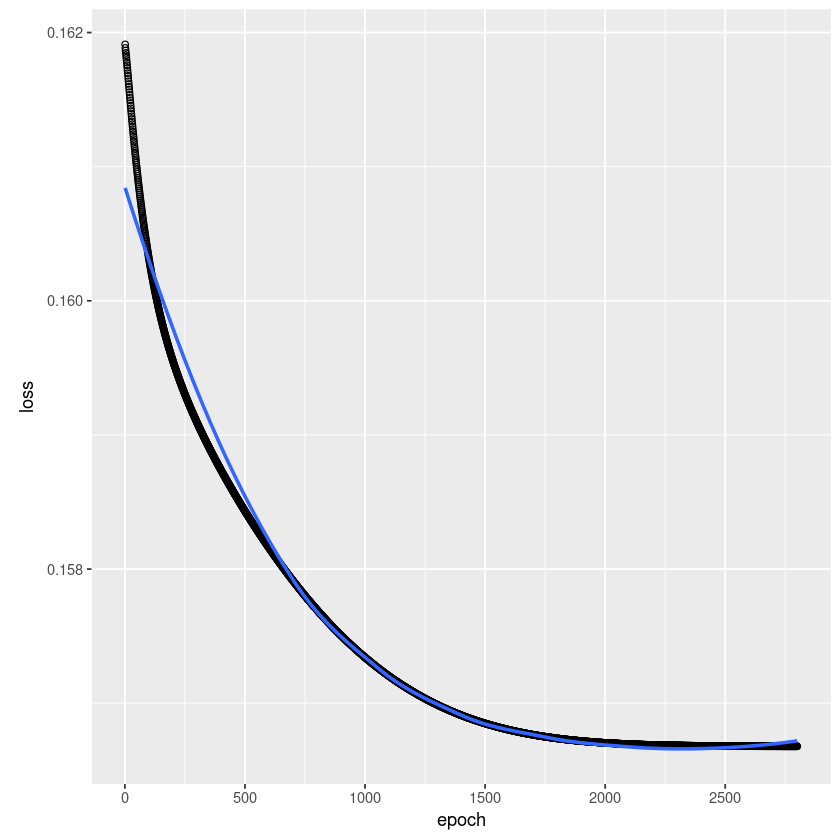

In [27]:
plot(fit)

## 5.4 Validation<a name="M1val"></a>

In [28]:
# calculating the predictions
train$fitglmNN <- as.vector(model_glm %>% predict(list(Xtrain, as.matrix(log(train$Exposure)))))
test$fitglmNN <- as.vector(model_glm %>% predict(list(Xtest, as.matrix(log(test$Exposure)))))

# average in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance shallow network (train): %s", PoissonDeviance(train$fitglmNN, train$ClaimNb))
sprintf("100 x Poisson deviance shallow network (test): %s", PoissonDeviance(test$fitglmNN, test$ClaimNb))

# average frequency
sprintf("Average frequency (test): %s", round(sum(test$fitglmNN) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance shallow network (train): 24.1578577334396"

[1] "100 x Poisson deviance shallow network (test): 24.2342830372812"

[1] "Average frequency (test): 0.0737"

In [29]:
trainable_params <- sum(unlist(lapply(model_glm$trainable_weights, k_count_params)))
df_cmp %<>% bind_rows(
  data.frame(model = "GLM with keras", epochs = epochs,
             run_time = round(exec_time[[3]], 0), parameters = trainable_params,
             in_sample_loss = round(PoissonDeviance(train$fitglmNN, train$ClaimNb), 4),
             out_sample_loss = round(PoissonDeviance(test$fitglmNN, test$ClaimNb), 4),
             avg_freq = round(sum(test$fitglmNN) / sum(test$Exposure), 4)
  ))

df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLM with keras,2800,244,39,24.1579,24.2343,0.0737


# 6. Generalized Linear Model using `glm(...)`<a name="M2"></a>

## 6.1 Fitting<a name="M2fit"></a>

In [30]:
exec_time <- system.time(
  glm1 <- glm(ClaimNb ~ AreaX + VehPowerX + VehAgeX + DrivAgeX + BonusMalusX + DensityX + VehGasX + VehBrand + Region,
              data = train, offset = log(Exposure), family = poisson())
)
exec_time[1:5]
summary(glm1)

user.self   sys.self    elapsed user.child  sys.child 
    11.425      1.466     12.906      0.000      0.000


Call:
glm(formula = ClaimNb ~ AreaX + VehPowerX + VehAgeX + DrivAgeX + 
    BonusMalusX + DensityX + VehGasX + VehBrand + Region, family = poisson(), 
    data = train, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.3729  -0.3255  -0.2472  -0.1396   6.9156  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.497636   0.041189 -36.360  < 2e-16 ***
AreaX        0.116014   0.053222   2.180  0.02927 *  
VehPowerX    0.188582   0.020202   9.335  < 2e-16 ***
VehAgeX     -0.173527   0.014874 -11.666  < 2e-16 ***
DrivAgeX     0.229850   0.018739  12.266  < 2e-16 ***
BonusMalusX  1.345937   0.019390  69.413  < 2e-16 ***
DensityX     0.193388   0.080645   2.398  0.01648 *  
VehGasX     -0.157057   0.014246 -11.024  < 2e-16 ***
VehBrandB2  -0.015839   0.019244  -0.823  0.41049    
VehBrandB3   0.051440   0.026613   1.933  0.05325 .  
VehBrandB4   0.050664   0.036061   1.405  0.16003    
VehBrandB5   0.093294   0.030

## 6.2 Validation<a name="M2val"></a>

In [31]:
# Predictions
train$fitGLM1 <- fitted(glm1)
test$fitGLM1 <- predict(glm1, newdata = test, type = "response")
dat$fitGLM1 <- predict(glm1, newdata = dat2, type = "response")

In [32]:
# in-sample and out-of-sample losses (in 10^(-2))
sprintf("100 x Poisson deviance GLM (train): %s", PoissonDeviance(train$fitGLM1, train$ClaimNb))
sprintf("100 x Poisson deviance GLM (test): %s", PoissonDeviance(test$fitGLM1, test$ClaimNb))

# Overall estimated frequency
sprintf("average frequency (test): %s", round(sum(test$fitGLM1) / sum(test$Exposure), 4))

[1] "100 x Poisson deviance GLM (train): 24.1578035936711"

[1] "100 x Poisson deviance GLM (test): 24.2344045952532"

[1] "average frequency (test): 0.0737"

In [33]:
df_cmp %<>% bind_rows(
  data.frame(model = "GLM with glm", epochs = NA, run_time = round(exec_time[[3]], 0), parameters = length(coef(glm1)),
             in_sample_loss = round(PoissonDeviance(train$fitGLM1, as.vector(unlist(train$ClaimNb))), 4),
             out_sample_loss = round(PoissonDeviance(test$fitGLM1, as.vector(unlist(test$ClaimNb))), 4),
             avg_freq = round(sum(test$fitGLM1) / sum(test$Exposure), 4))
)
df_cmp

model,epochs,run_time,parameters,in_sample_loss,out_sample_loss,avg_freq
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GLM with keras,2800,244,39,24.1579,24.2343,0.0737
GLM with glm,NA,13,39,24.1578,24.2344,0.0737


# 7. Model Comparison<a name="MC"></a>

### 7.1 Compare fitted values<a name="MCfit"></a>

In [34]:
plot_claims_freq <- function(xvar, yvar, xlab, ylab) {
  axis_min <- log(max(test[[xvar]], test[[yvar]]))
  axis_max <- log(min(test[[xvar]], test[[yvar]]))
  
  ggplot(test, aes(x = log(!!sym(xvar)), y = log(!!sym(yvar)), colour = Exposure)) + geom_point() +
    geom_abline(colour = "#000000", slope = 1, intercept = 0) +
    xlim(axis_max, axis_min) + ylim(axis_max, axis_min) +
    labs(x = xlab, y = ylab, title = "Claims frequency prediction (log-scale)") +
    scale_colour_gradient(low = "green", high = "red")
}

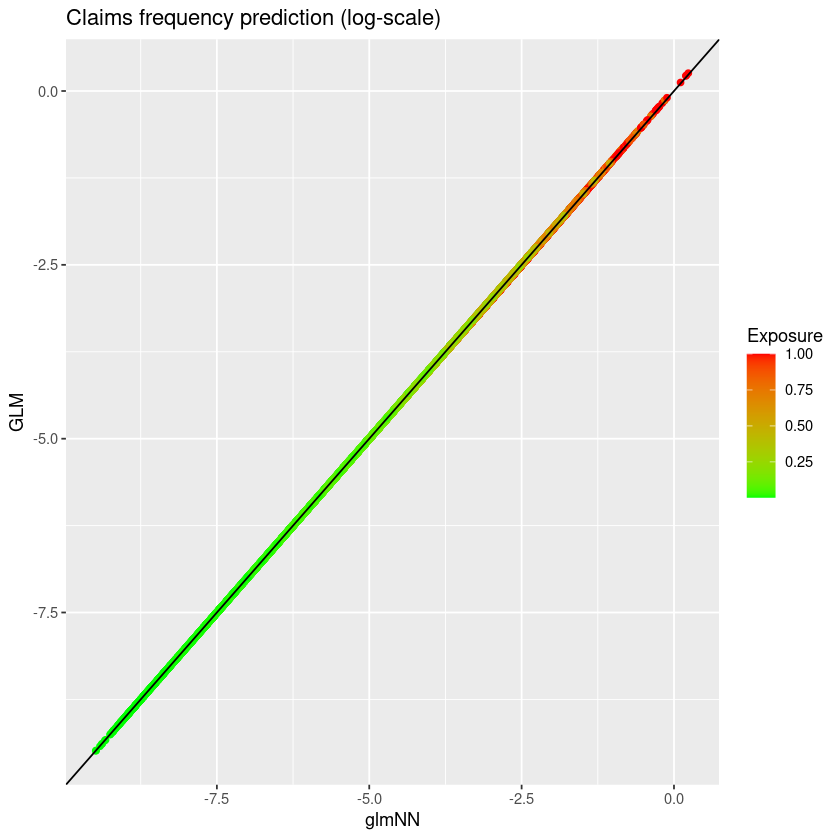

In [35]:
plot_claims_freq("fitglmNN", "fitGLM1", "glmNN", "GLM")

### 7.2 Compare coefficients/weights<a name="MCcoef"></a>

In [36]:
df_coef <- data.frame(glm=coef(glm1),keras=c(get_weights(model_glm)[[2]],get_weights(model_glm)[[1]]))

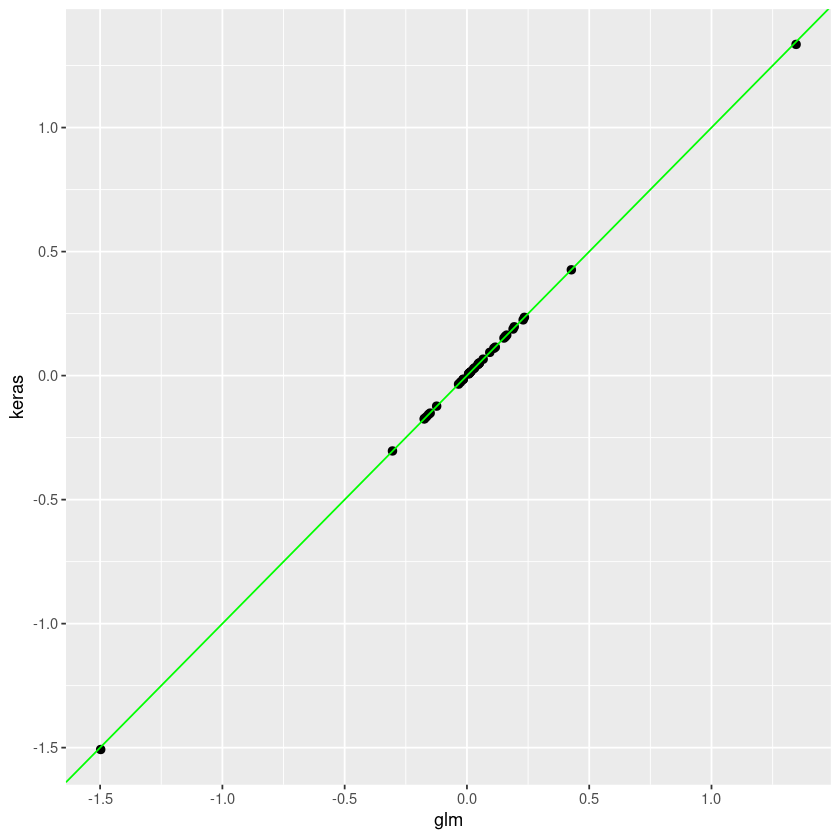

In [37]:
ggplot(df_coef,aes(x=glm,y=keras)) + geom_point(size=2) + geom_abline(intercept=0, slope=1, col="green")

In [38]:
head(df_coef, n=10)

,glm,keras
,<dbl>,<dbl>
(Intercept),-1.49763558,-1.50749433
AreaX,0.11601366,0.11477026
VehPowerX,0.18858234,0.18776892
VehAgeX,-0.17352658,-0.17288700
DrivAgeX,0.22984962,0.22471580
BonusMalusX,1.34593742,1.33544743
DensityX,0.19338782,0.19686709
VehGasX,-0.15705729,-0.15676792
VehBrandB2,-0.01583881,-0.01561991


# 8. Remarks<a name="rmk"></a>

Some final remarks as follows:
- A GLM is a special case of a neural network
- A GLM can be fit using `keras()`
- The number of epochs needs to be high to reach convergence
- There is no reason to fit a glm with `keras()`

# 9. Session Info<a name="session"></a>

The html is generated with the follow packages (which migth be slightly newer than the ones used in the published tutorial).

In [39]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] farff_1.1        OpenML_1.10      tidyr_1.1.2      splitTools_0.3.1
 [5] gridExtra_2.3    ggplot2_3.3.3    purrr_0.3.4      tibble_3.0.5    
 [9] dplyr_1.0.3      magrittr_2.0.1   keras_2.3.0.0    mgcv_1.8-33     
[13] nlme_3.1-151    

loaded via a namespace (an

In [40]:
reticulate::py_config()

python:         /usr/bin/python3
libpython:      /usr/lib/python3.8/config-3.8-x86_64-linux-gnu/libpython3.8.so
pythonhome:     //usr://usr
version:        3.8.10 (default, Sep 28 2021, 16:10:42)  [GCC 9.3.0]
numpy:          /usr/local/lib/python3.8/dist-packages/numpy
numpy_version:  1.20.1
tensorflow:     /usr/local/lib/python3.8/dist-packages/tensorflow

python versions found: 
 /usr/bin/python3
 /usr/bin/python

In [41]:
tensorflow::tf_version()

[1] ‘2.4’